# AOTF analysis

In this notebook, we generate the figures related to the AOTF triggering. In order to download the data, run the [download_data notebook](0_download_data.ipynb) first. 

The data comes as \*.txt files generated by a Teledyne Lecroy LECROYHDO4054 oscilloscope, and were acquired using the python scripts found in the [MicroFPGA-py repository](https://github.com/mufpga/MicroFPGA-py/tree/main/examples) (`example07` and `fig_aotf`). 

The data was generated using the AOTF-CB.

In [1]:
import os, re
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# define some matplotlib style for all figures
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [2]:
def load_single(path):
    '''
    Load a single file and return a 2D list (time, value).
    '''
    with open(path) as f:
        lines = f.readlines()[5:]    
        v = np.zeros((len(lines), 2))
    
        for i in range(len(lines)):
            split = lines[i].split('\t')
            v[i,0] = float(split[0])
            v[i,1] = float(split[1])
    
        return v
    
def load_all(path):
    '''
    Load all *.txt files contained in path and returns a list of 2D lists (time, value).
    '''
    vals_list = []
    f_list = [f for f in os.listdir(path) if f.endswith('.txt')]
    
    if path.endswith(os.path.sep):
        new_path = path
    else:
        new_path = path+os.path.sep
    
    for f in f_list:
        vals_list.append(load_single(new_path+f))
        
    return vals_list

    
def get_delays(v_list, threshold = 2, inverted = False):
    '''
    Return the first time point at which each element of v_list crosses the threshold 
    from smaller values.
    '''
    ds = []
    
    for v in v_list:
        t = v[get_delay_index(v, threshold), 0]
              
        ds.append(t)
    
    return np.array(ds)


def get_delay_index(v, threshold = 2):
    return np.argmax(v[:,1] > threshold)

# Conveniance methods to set the x-axis title
def s():
    return 'time (s)'

def ms():
    return 'time (ms)'

def us():
    return 'time (\u03bcs)'

def ns():
    return 'time (ns)'


timing = {1 : s,
          1_000 : ms,
          1_000_000 : us,
          1_000_000_000 : ns
}

def get_time(time_scale):
    return timing[time_scale]()

## AOTF trigger

The data was acquired using the `fig_aotf` script.

In [5]:
# load data
root  = op.join('data','aotf','triggering')
laser = load_single(op.join(root,'C1_00000.txt'))
all_vals = load_all(op.join(root,'ch3'))

all_vals = all_vals[0:268]
print(f'Number of measurements: {len(all_vals)}')


Number of measurements: 268


In [6]:
# voltage(t0)=2 might not be exactly at t0 = 0s. Even though the value is expected to be quite small, 
# we compute it here
ind = get_delay_index(laser, 2)
t0 = laser[ind, 0]
print(f'Crossing time {t0} s, voltage(t0-1)={laser[ind-1,1]} and voltage(t0)={laser[ind,1]}')

Crossing time 1.910449e-09 s, voltage(t0-1)=1.988 and voltage(t0)=2.092


In [7]:
# compute delay for all laser signals
delays = (get_delays(all_vals, threshold=0.3)-t0)*1_000_000_000  # to ns
print(f'Delay {np.mean(delays)} +/- {np.std(delays)} ns')
print(f'Min delay {np.min(delays)}, Median {np.median(delays)}, Max delay {np.max(delays)}')

Delay 80.14682659701492 +/- 1.4283448165143626 ns
Min delay 67.43593100000001, Median 80.30182100000002, Max delay 82.105331


indices: [150, 217, 90]


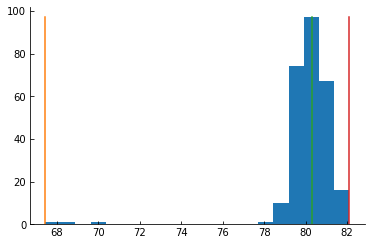

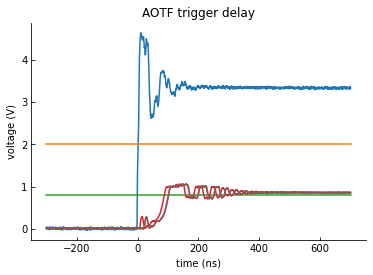

In [8]:
# Plot the camera exposure signal and the min/median/max delayed laser trigger signals
def plot_histo(vals, vertical):
    '''
    Plot an histogram with vertical lines.
    '''
    y, x, _ = plt.hist(vals, bins = 20, density=False)
    
    for v in vertical:
        plt.plot([v, v], [0, max(y)])
    
    plt.show()
    
def plot_panel_a(ref, v_list, time_scale = 1):
    '''
    Plot figure panel a.
    '''
    plt.figure()
    plt.plot(ref[:,0]*time_scale,ref[:,1]) # laser trigger
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [2, 2]) # HIGH threshold
    plt.plot([ref[0,0]*time_scale, ref[-1,0]*time_scale], [0.8, 0.8]) # LOW threshold
    for v in v_list:
        plt.plot(v[:,0]*time_scale,v[:,1]) # AOTF   
        
    plt.title('AOTF trigger delay')
    plt.xlabel(get_time(time_scale))
    plt.ylabel('voltage (V)')
    #plt.xlim(-50,150)
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_aotf_triggering.eps'), format='eps')

# get the indices of the min/median/max delayed signals
i_s = [np.argmax(delays == np.min(delays)),
       np.argmin(abs(delays - np.median(delays))),
       np.argmax(delays == np.max(delays))]
vals = [all_vals[i] for i in i_s]
print(f'indices: {i_s}')

# sanity check: the median, min and max delays really are so (colors will be different from the next plot)
plot_histo(delays, delays[i_s]) 

# plot the min/median/max delayed signals with the x-axis in ns 
plot_panel_a(laser, vals, time_scale = 1_000_000_000)

## AOTF demo

This data was acquired using the `example07_aotf` script. It demonstrates the change of the AOTF analog value while triggering the signal with a laser output from MicroFPGA.

In [9]:
# load data
root  = op.join('data','aotf','demo')
laser = load_single(op.join(root,'C1_00000.txt'))
pwm = load_single(op.join(root,'C2_00000.txt'))
aotf = load_single(op.join(root,'C3_00000.txt'))

In [94]:
def get_pulses(v):
    """
    Run through the signal and extract pulse lengths, 
    as well as start and end times of each pulse.
    """
    # detect rising and falling pulses
    t0 = []
    t1 = []
    for i in range(len(v)-1):
        if v[i,1] <= 2 < v[i+1,1]:
            t0.append(v[i, 0])

        if v[i,1] >= 2 > v[i+1,1]:
            t1.append(v[i, 0])
                    
    assert len(t0) == len(t1)
    
    # list pulses and the corresponding time
    pulses = np.array([t1[i]-t0[i] for i in range(len(t1))])
    pulses_t0 = np.array(t0)
    pulses_t1 = np.array(t1)
    
    return pulses, pulses_t0, pulses_t1

def get_duty_cycle(pulses, pulses_t0, pulses_t1):
    """
    Convert the results from get_pulses into a duty_cycle curve.
    """
    avg_pulses = []
    avg_pulses_t = []
    
    current_pulses = []
    current_times = []
    
    last_segment_end = pulses_t0[0]
    
    for i, p in enumerate(pulses):
        
        if not current_pulses: # if empty, add the first pulse
            current_pulses.append(p)
            current_times.append(pulses_t0[i])
            
        else:
            # check if time difference corresponds to a transition between PWM state
            # (PWM change every 250 ms in the script, period of PWM is 1.3 ms)
            if pulses_t0[i] - pulses_t1[i-1] < 0.1:
                
                if abs(p - current_pulses[-1]) < 0.0001 and i < len(pulses)-1: # we consider it is the same PWM value
                    
                    current_pulses.append(p)
                    current_times.append(pulses_t0[i])
                    
                else: # there is a step increase/decrease
                    
                    # average previous pulses
                    avg_p = np.mean(current_pulses)
                    
                    # start and end of the new duty cycle segment
                    t_start = last_segment_end + (current_times[0]-last_segment_end) / 2
                    t_end = pulses_t1[i-1] + (pulses_t0[i]-pulses_t1[i-1]) / 2
                    last_segment_end = t_end
                    
                    # add points
                    avg_pulses.extend( [avg_p, avg_p] )
                    avg_pulses_t.extend( [t_start, t_end] )

                    # empty current pulse
                    current_pulses.clear()
                    current_times.clear()
                    
                    # add the latest one
                    current_pulses.append(p)
                    current_times.append(pulses_t0[i])
                    
            else: # transition from or to 0
                
                # average previous pulses
                avg_p = np.mean(current_pulses)
                    
                # start and end of the new duty cycle segment
                t_start = last_segment_end + (current_times[0]-last_segment_end) / 2
                t_end = pulses_t1[i-1]
                last_segment_end = pulses_t0[i]
                    
                # add points
                avg_pulses.extend( [avg_p, avg_p] )
                avg_pulses_t.extend( [t_start, t_end] )
                    
                # add zero transition
                avg_pulses.extend( [0, 0] )
                avg_pulses_t.extend( [t_end, last_segment_end] )
                    
                # empty current pulse
                current_pulses.clear()
                current_times.clear()
                    
                # add the latest one
                current_pulses.append(p)
                current_times.append(pulses_t0[i])
    
    duty_cycle = np.array(avg_pulses) / np.max(avg_pulses)
    
    return np.array([avg_pulses_t, duty_cycle]).T

(array([3012.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  772.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  589.,  184.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  771.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  770.]),
 array([0.000215  , 0.00023242, 0.00024984, 0.00026726, 0.00028468,
        0.0003021 , 0.00031952, 0.00033694, 0.00035436, 0.00037178,
        0.0003892 , 0.00040662, 0.00042404, 0.00044146, 0.00045888,
        0.0004763 , 0.00049372, 0.00051114, 0.00052856, 0.00054598,
        0.0005634 , 0.00058082, 0.00059824, 0.00061566, 0.00063308,
        0.0006505 , 0.00066792, 0.00068534, 0.00070276, 0.00072018,
        0.0007376 , 0.00075502, 0.00077244, 0.00078986, 0.00080728,
        0.0008247 , 0.00084212, 0.00085954, 0.00087696, 0.00089438,
        0.0009118 , 0.00092922, 0.00094664, 0.00096406, 

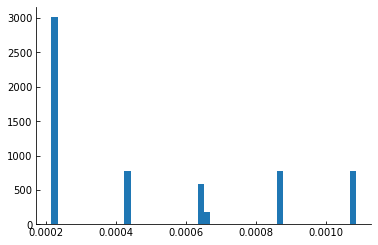

In [58]:
# extract pulses
lst_pulses, lst_starts, lst_ends = get_pulses(pwm)

# check that the pulses are one of the 5 non-zero steps
plt.hist(lst_pulses, bins = 50)

(18, 2)
[[-1.99908477  0.19811126]
 [-0.01174777  0.19811126]
 [-0.01174777  0.        ]
 [ 1.01684923  0.        ]
 [ 1.01684923  0.19811245]
 [ 2.02814273  0.19811245]
 [ 2.02841548  0.4009414 ]
 [ 3.03617523  0.4009414 ]
 [ 3.03639273  0.59905608]
 [ 4.04551073  0.59905608]
 [ 4.04567448  0.80188565]
 [ 5.05223773  0.80188565]
 [ 5.05234648  1.        ]
 [ 6.05754623  1.        ]
 [ 6.05754623  0.        ]
 [ 7.06830023  0.        ]
 [ 7.06830023  0.19811555]
 [ 7.99864673  0.19811555]]


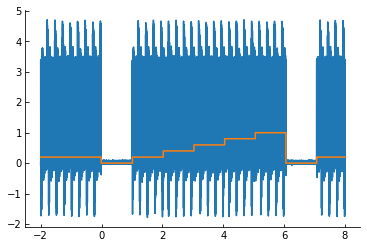

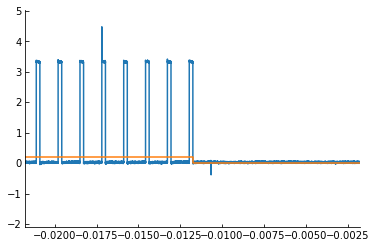

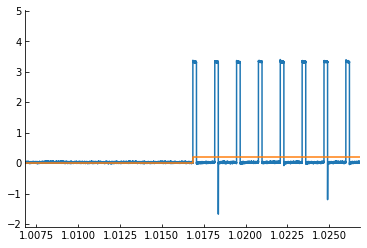

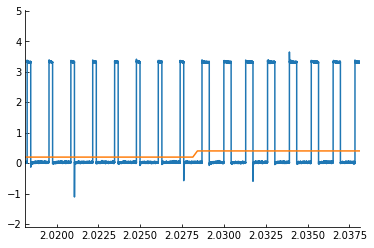

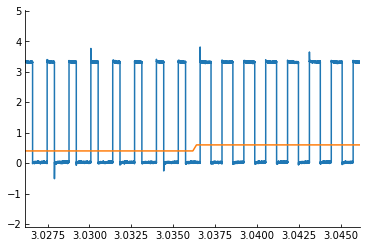

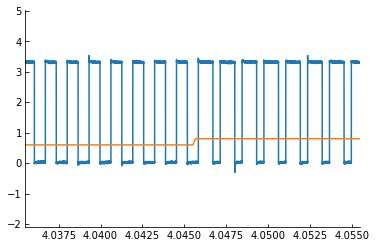

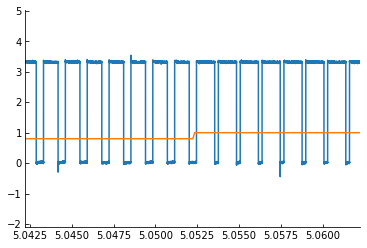

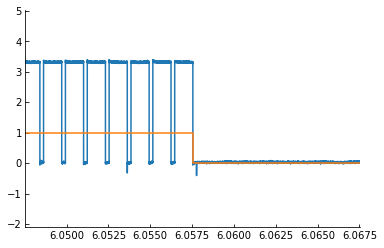

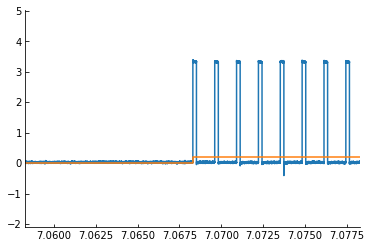

In [97]:
# convert to duty cycle
duty_cycle = get_duty_cycle(lst_pulses, lst_starts, lst_ends)
print(duty_cycle.shape)
print(duty_cycle)

# compare with the PWM
plt.figure()
plt.plot(pwm[:, 0], pwm[:, 1])
plt.plot(duty_cycle[:, 0], duty_cycle[:, 1] )
plt.show()

# check that transitions occur at a change of PWM
for i in range(duty_cycle.shape[0]-1):
    if i % 2 == 1: 
        t = duty_cycle[i, 0]

        plt.figure()
        plt.plot(pwm[:, 0], pwm[:, 1])
        plt.plot(duty_cycle[:, 0], duty_cycle[:, 1] )
        plt.xlim(t-0.01, t+0.01)

        plt.show()

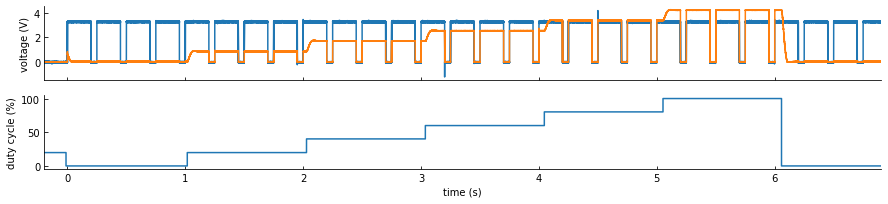

<Figure size 432x288 with 0 Axes>

In [107]:
def plot_wide_b(ref, v, w, time_scale = 1):
    '''
    Plot all elements (time, value) of v_list in a wide plot. 
    time_scale allows changing the unit of the x-axis.
    '''
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 3))
    
    ax1.plot(ref[:, 0] * time_scale, ref[:, 1])
    ax1.plot(w[:, 0] * time_scale, w[:, 1])
    ax1.set_ylabel('voltage (V)')

    ax2.plot(v[:, 0] * time_scale, 100 * v[:, 1])
    ax2.set_xlabel(get_time(time_scale))
    ax2.set_xlim(-0.2, 6.9)
    ax2.set_ylabel('duty cycle (%)')
    
    plt.show()
    
    dir_path = 'figs'
    if not os.path.isdir(dir_path): os.mkdir(dir_path)
    plt.savefig(op.join(dir_path,'fig_aotf_demo.eps'), format='eps')

# plot the figure
plot_wide_b(laser, duty_cycle, aotf)